In [1]:
# === PROJECT ROOT & FOLDERS ===
import os, pathlib

BASE_DIR = os.path.expanduser("~/Desktop/bonds_project")
DATA_DIR = os.path.join(BASE_DIR, "data")
FIGS_DIR = os.path.join(BASE_DIR, "figs")
SRC_DIR  = os.path.join(BASE_DIR, "src")

for d in (BASE_DIR, DATA_DIR, FIGS_DIR, SRC_DIR):
    os.makedirs(d, exist_ok=True)

print("Project root:", BASE_DIR)


Project root: /Users/oltimyrtaj/Desktop/bonds_project


In [2]:
# === INSTALLS (safe to re-run) ===
import sys, subprocess, pkgutil
def _pip_install(spec): subprocess.check_call([sys.executable, "-m", "pip", "install", spec])

need = {
    "pandas": "pandas>=1.5,<2.0",
    "numpy": "numpy>=1.21,<2.0",
    "scipy": "scipy>=1.7,<1.11",
    "matplotlib": "matplotlib>=3.5,<3.8",
    "yfinance": "yfinance>=0.2.30,<0.3",
    "pandas_datareader": "pandas-datareader>=0.10.0",
    "python_dateutil": "python-dateutil>=2.8",
}
for mod, spec in need.items():
    if pkgutil.find_loader(mod) is None:
        _pip_install(spec)

# fredapi is optional (we auto-fallback to pandas-datareader if no key)
if pkgutil.find_loader("fredapi") is None:
    try:
        _pip_install("fredapi>=0.5")
    except Exception:
        pass

# === IMPORTS & PLOTTING ===
import os, time, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["axes.grid"] = True

# Optional: if you *have* a FRED key, set it here. Otherwise we use pandas-datareader.
# import os; os.environ["FRED_API_KEY"] = "YOUR_KEY_HERE"



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# === FRED BACKEND CHOICE ===
FRED_SERIES = {
    1:  "DGS1",  2:  "DGS2",  3:  "DGS3",  5:  "DGS5",
    7:  "DGS7", 10: "DGS10", 20: "DGS20", 30: "DGS30",
}

def _which_fred_backend():
    try:
        import fredapi  # noqa
        return "fredapi"
    except Exception:
        try:
            from pandas_datareader import data as _  # noqa
            return "pdr"
        except Exception:
            return "none"

_FRED_BACKEND = _which_fred_backend()

def fetch_fred_yields(start="2018-01-01", end=None, tenors=None):
    """
    Return daily Treasury yields (%) with columns y_2, y_5, y_10, y_30, ...
    Uses fredapi if FRED_API_KEY is set; otherwise falls back to pandas_datareader('fred').
    """
    if tenors is None:
        tenors = [2,5,10,30]
    if end is None:
        end = dt.date.today().isoformat()
    ids = {k: FRED_SERIES[k] for k in tenors}

    # If fredapi detected but no key, force pdr
    if _FRED_BACKEND == "fredapi" and not os.getenv("FRED_API_KEY"):
        backend = "pdr"
    else:
        backend = _FRED_BACKEND

    if backend == "fredapi":
        from fredapi import Fred
        fred = Fred(api_key=os.getenv("FRED_API_KEY"))
        frames = {}
        for y, sid in ids.items():
            s = fred.get_series(sid, observation_start=start, observation_end=end)
            s.index = pd.to_datetime(s.index)
            frames["y_%d" % y] = pd.Series(s, name="y_%d" % y).astype(float)
        return pd.concat(frames.values(), axis=1).sort_index()

    if backend == "pdr":
        from pandas_datareader import data as pdr
        frames = {}
        for y, sid in ids.items():
            s = pdr.DataReader(sid, "fred", start, end).squeeze("columns")
            frames["y_%d" % y] = s.rename("y_%d" % y).astype(float)
        return pd.concat(frames.values(), axis=1).sort_index()

    raise ImportError("Install fredapi (with FRED_API_KEY) or pandas-datareader to fetch FRED data.")

def fetch_overlay_prices(tickers=None, start="2018-01-01", end=None, max_retries=3, backoff_seconds=5):
    """
    Fetch overlay proxies (e.g., IEF, TLT).
    Try Yahoo first (yfinance) with small backoff; if rate-limited, fall back to Stooq via pandas_datareader.
    Returns wide DataFrame of adjusted close prices (columns = tickers).
    """
    if tickers is None:
        tickers = ["IEF","TLT"]
    if end is None:
        end = dt.date.today().isoformat()

    import yfinance as yf
    last_err = None
    for attempt in range(max_retries):
        try:
            df = yf.download(
                tickers, start=start, end=end,
                auto_adjust=True, progress=False, group_by="ticker",
                threads=False  # reduce chance of rate-limit
            )
            if isinstance(df.columns, pd.MultiIndex):
                frames = []
                for t in tickers:
                    if (t, "Close") in df.columns:
                        frames.append(df[(t, "Close")].rename(t))
                if frames:
                    out = pd.concat(frames, axis=1).sort_index()
                    if not out.empty:
                        return out
            else:
                if "Close" in df.columns:
                    out = df["Close"].to_frame()
                    out.columns = tickers[:1]
                    if not out.empty:
                        return out
        except Exception as e:
            last_err = e
        time.sleep(backoff_seconds * (attempt + 1))

    # Fallback: Stooq
    try:
        from pandas_datareader import data as pdr
    except Exception as e:
        if last_err:
            raise last_err
        raise ImportError("Install pandas-datareader for Stooq fallback.") from e

    frames = []
    for t in tickers:
        got = False
        try:
            s = pdr.DataReader(t, "stooq", start, end).sort_index()
            s = s["Close"].rename(t)
            frames.append(s); got = True
        except Exception:
            pass
        if not got:
            try:
                s = pdr.DataReader(t + ".us", "stooq", start, end).sort_index()
                s = s["Close"].rename(t)
                frames.append(s); got = True
            except Exception:
                pass

    if not frames:
        if last_err:
            raise last_err
        raise RuntimeError("Failed to fetch prices from Yahoo and Stooq.")
    return pd.concat(frames, axis=1).sort_index()

def align_and_fill(yields_df, prices_df):
    """Outer-join by date; forward-fill modest gaps; drop all-null rows."""
    df = yields_df.join(prices_df, how="outer")
    df = df.sort_index().ffill(limit=5)
    df = df.dropna(how="all")
    return df

def add_simple_returns(panel, tickers):
    for t in tickers:
        if t in panel.columns:
            panel[t + "_ret"] = panel[t].pct_change()
    return panel

def build_dataset(start="2018-01-01", end=None, tenors=(2,5,10,30), overlays=("IEF","TLT")):
    y = fetch_fred_yields(start=start, end=end, tenors=list(tenors))
    p = fetch_overlay_prices(tickers=list(overlays), start=start, end=end)
    panel = align_and_fill(y, p)
    panel = add_simple_returns(panel, list(overlays))
    out_path = os.path.join(DATA_DIR, "market_panel.csv")
    panel.to_csv(out_path, index=True)
    print("Saved dataset ->", out_path)
    print("Columns:", list(panel.columns))
    return panel


In [4]:
panel = build_dataset(
    start="2018-01-01",
    tenors=(2,5,10,30),
    overlays=("IEF","TLT"),
)
panel.tail()


2 Failed downloads:
['TLT', 'IEF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

2 Failed downloads:
['TLT', 'IEF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

2 Failed downloads:
['TLT', 'IEF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Saved dataset -> /Users/oltimyrtaj/Desktop/bonds_project/data/market_panel.csv
Columns: ['y_2', 'y_5', 'y_10', 'y_30', 'IEF', 'TLT', 'IEF_ret', 'TLT_ret']


,y_2,y_5,y_10,y_30,IEF,TLT,IEF_ret,TLT_ret
2025-10-14,3.48,3.60,4.03,4.62,97.21,90.86,0.002578,0.003202
2025-10-15,3.50,3.63,4.05,4.64,97.10,90.66,-0.001132,-0.002201
2025-10-16,3.41,3.55,3.99,4.58,97.55,91.34,0.004634,0.007501
2025-10-17,3.46,3.59,4.02,4.60,97.39,91.20,-0.001640,-0.001533
2025-10-20,3.46,3.59,4.02,4.60,97.52,91.54,0.001335,0.003728


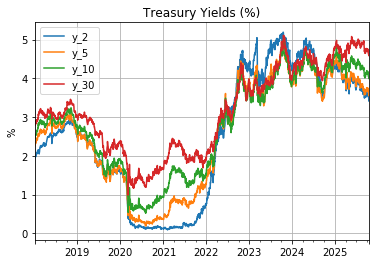

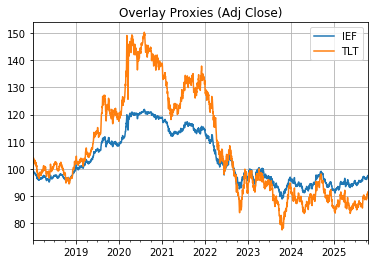

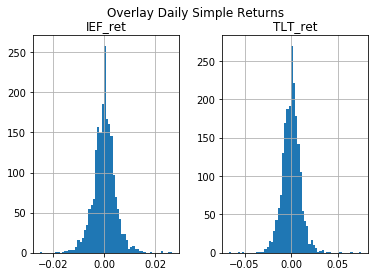

NaN counts per column:
 IEF_ret    1
TLT_ret    1
y_2        0
y_5        0
y_10       0
y_30       0
IEF        0
TLT        0
dtype: int64

Most recent 5 dates with both yields & overlays: [Timestamp('2025-10-14 00:00:00'), Timestamp('2025-10-15 00:00:00'), Timestamp('2025-10-16 00:00:00'), Timestamp('2025-10-17 00:00:00'), Timestamp('2025-10-20 00:00:00')]


In [5]:
# Yields
ax = panel[['y_2','y_5','y_10','y_30']].plot(title="Treasury Yields (%)")
ax.set_ylabel("%"); plt.show()

# Overlay proxies (Adj Close)
panel[['IEF','TLT']].plot(title="Overlay Proxies (Adj Close)")
plt.show()

# Daily returns hist
panel[['IEF_ret','TLT_ret']].dropna().hist(bins=60)
plt.suptitle("Overlay Daily Simple Returns"); plt.show()

# Integrity
print("NaN counts per column:\n", panel.isna().sum().sort_values(ascending=False))
both = panel[['y_2','y_5','y_10','y_30','IEF','TLT']].dropna().index
print("\nMost recent 5 dates with both yields & overlays:", list(both[-5:]))